<a href="https://colab.research.google.com/github/nicolassalomon96/aprendizaje_maquina_UNS/blob/master/TP4/Clasificadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP4 - Clasificadores

El objetivo de este proyecto es construir un modelo capaz de predecir el diagnóstico de tejidos de cáncer de mama como malignos o benignos. Las características se calculan a partir de una imagen digitalizada de un aspirado con aguja fina (FNA, por sus siglas en inglés) de una masa mamaria. Describen características de los núcleos celulares presentes en la imagen. Distribución de clases: 357 benignas, 212 malignas.

## 1. Librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn import svm

from tensorflow import keras

## 2. Descarga y analisis del dataset

In [ ]:
df_cancer = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBCD/data/data.csv")
display(df_cancer.head())
display(df_cancer.describe())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [ ]:
#Eliminamos columnas innecesarias
df1 = df_cancer.drop(['id','Unnamed: 32'], axis=1)

#Separamos el dataset en mean, se y worst
df_mean = df1.loc[:, 'radius_mean':'fractal_dimension_mean']
df_mean['diagnosis'] = df1['diagnosis']

df_se = df1.loc[:, 'radius_se':'fractal_dimension_se']
df_se['diagnosis'] = df1['diagnosis']

df_worst = df1.loc[:, 'radius_worst':'fractal_dimension_worst']
df_worst['diagnosis'] = df1['diagnosis']

display(df_mean.sample(5))
display(df_se.sample(5))
display(df_worst.sample(5))

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,diagnosis
452,12.00,28.23,76.77,442.5,0.08437,0.06450,0.04055,0.01945,0.1615,0.06104,B
375,16.17,16.07,106.30,788.5,0.09880,0.14380,0.06651,0.05397,0.1990,0.06572,B
227,15.00,15.51,97.45,684.5,0.08371,0.10960,0.06505,0.03780,0.1881,0.05907,B
50,11.76,21.60,74.72,427.9,0.08637,0.04966,0.01657,0.01115,0.1495,0.05888,B
77,18.05,16.15,120.20,1006.0,0.10650,0.21460,0.16840,0.10800,0.2152,0.06673,M


,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,diagnosis
146,0.3197,1.4260,2.281,24.720,0.005427,0.03633,0.04649,0.018430,0.05628,0.004635,M
379,0.2114,1.0270,1.719,13.990,0.007405,0.04549,0.04588,0.013390,0.01738,0.004435,M
414,0.4681,1.6270,3.043,45.380,0.006831,0.01427,0.02489,0.009087,0.03151,0.001750,M
231,0.1210,0.8927,1.059,8.605,0.003653,0.01647,0.01633,0.003125,0.01537,0.002052,B
250,1.0040,0.8208,6.372,137.900,0.005283,0.03908,0.09518,0.018640,0.02401,0.005002,M


,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
404,13.18,16.85,84.11,533.1,0.1048,0.06744,0.04921,0.04793,0.2298,0.05974,B
437,15.66,21.58,101.20,750.0,0.1195,0.12520,0.11170,0.07453,0.2725,0.07234,B
546,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399,B
556,10.65,22.88,67.88,347.3,0.1265,0.12000,0.01005,0.02232,0.2262,0.06742,B
468,21.57,28.87,143.60,1437.0,0.1207,0.47850,0.51650,0.19960,0.2301,0.12240,M


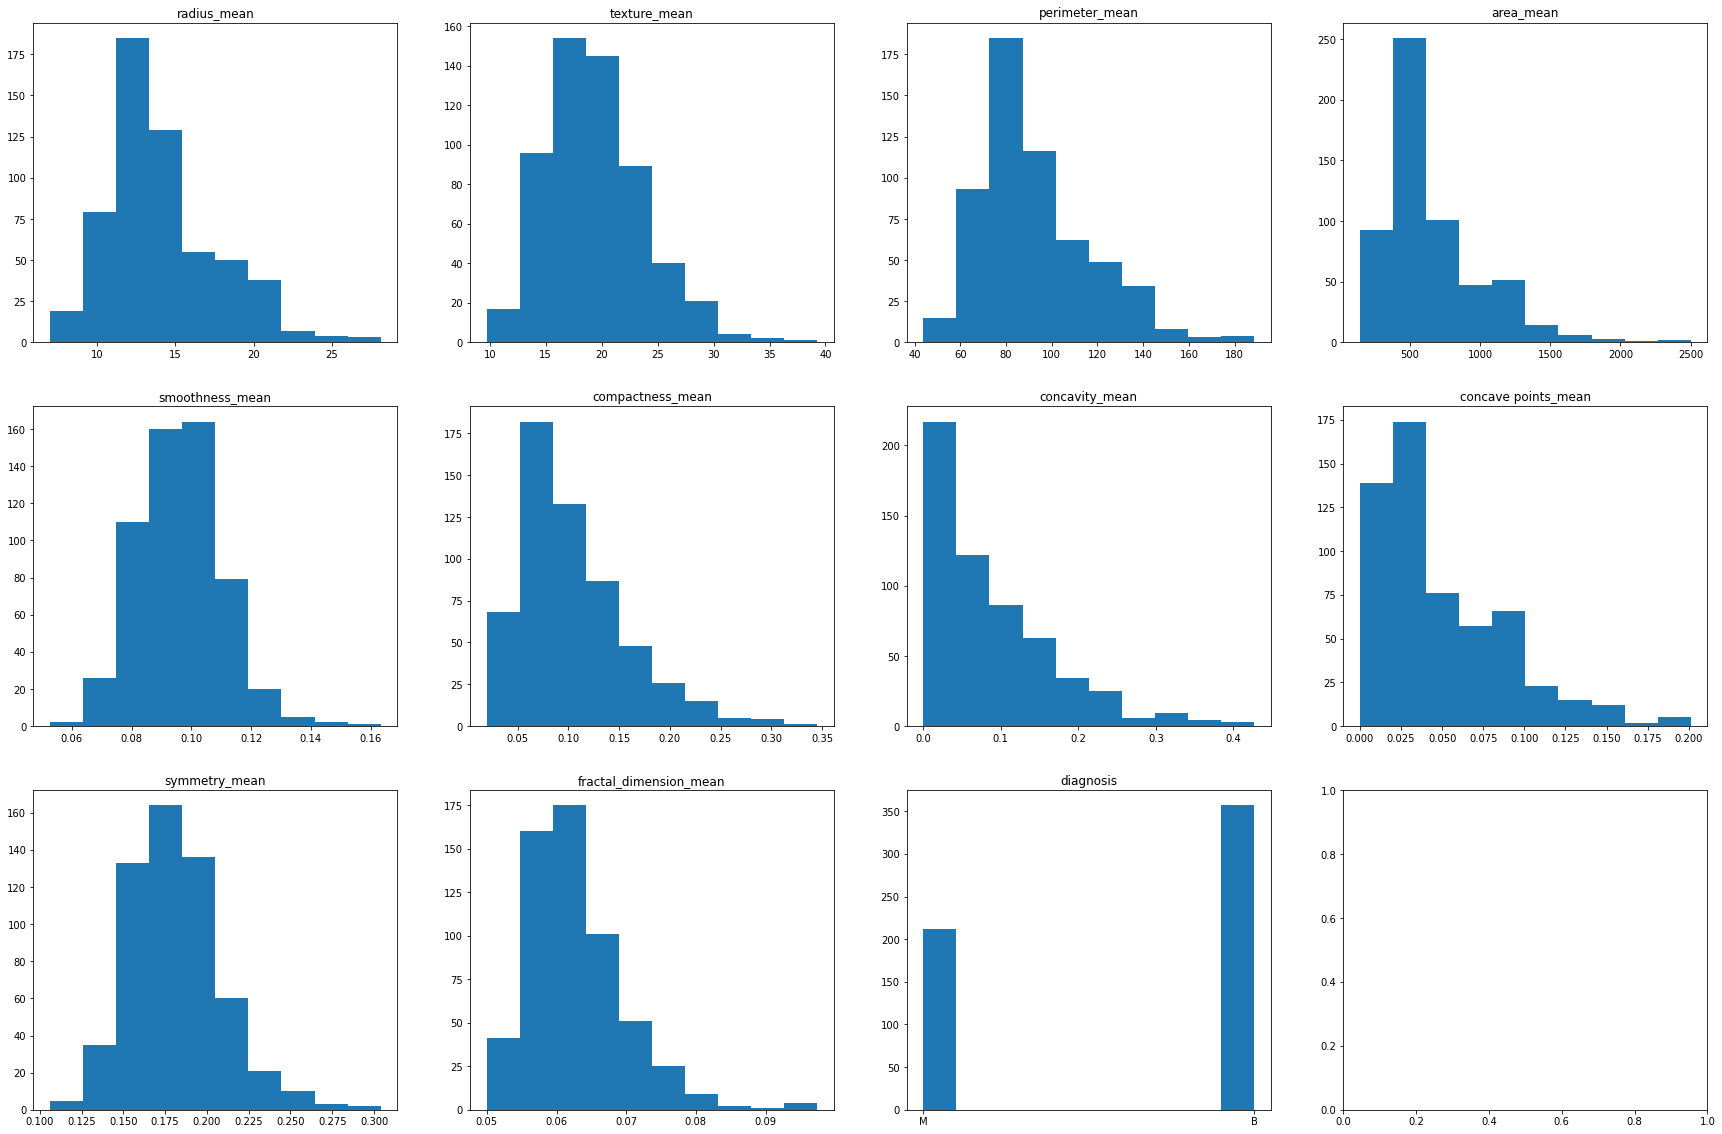

In [ ]:
rows, columns = 3, 4
fig, axs = plt.subplots(rows,columns,figsize=(30,20))
k = 0
for i in range(rows):
  for j in range(columns):
    if k <= 10:
      axs[i,j].hist(df_mean[df_mean.columns.values[k]])
      axs[i,j].set_title(df_mean.columns.values[k])
      k += 1

plt.show()


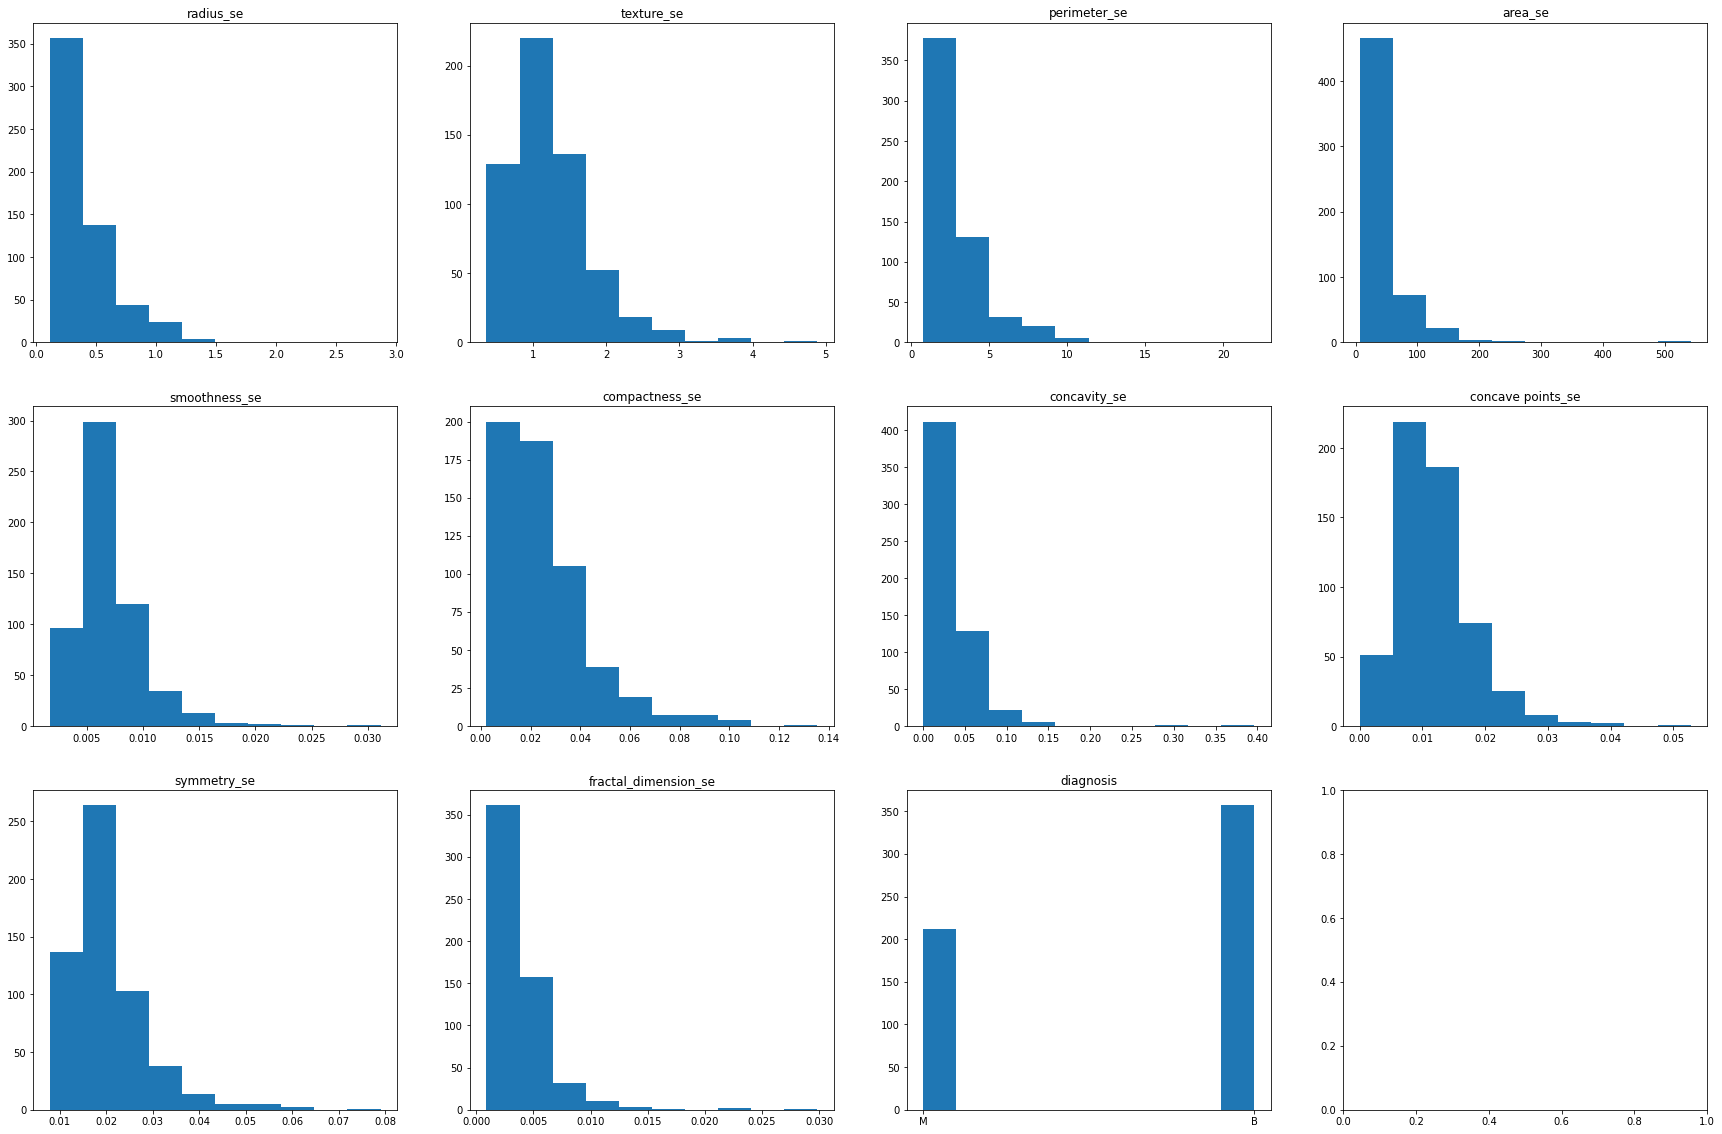

In [ ]:
rows, columns = 3, 4
fig, axs = plt.subplots(rows,columns,figsize=(30,20))
k = 0
for i in range(rows):
  for j in range(columns):
    if k <= 10:
      axs[i,j].hist(df_se[df_se.columns.values[k]])
      axs[i,j].set_title(df_se.columns.values[k])
      k += 1

plt.show()

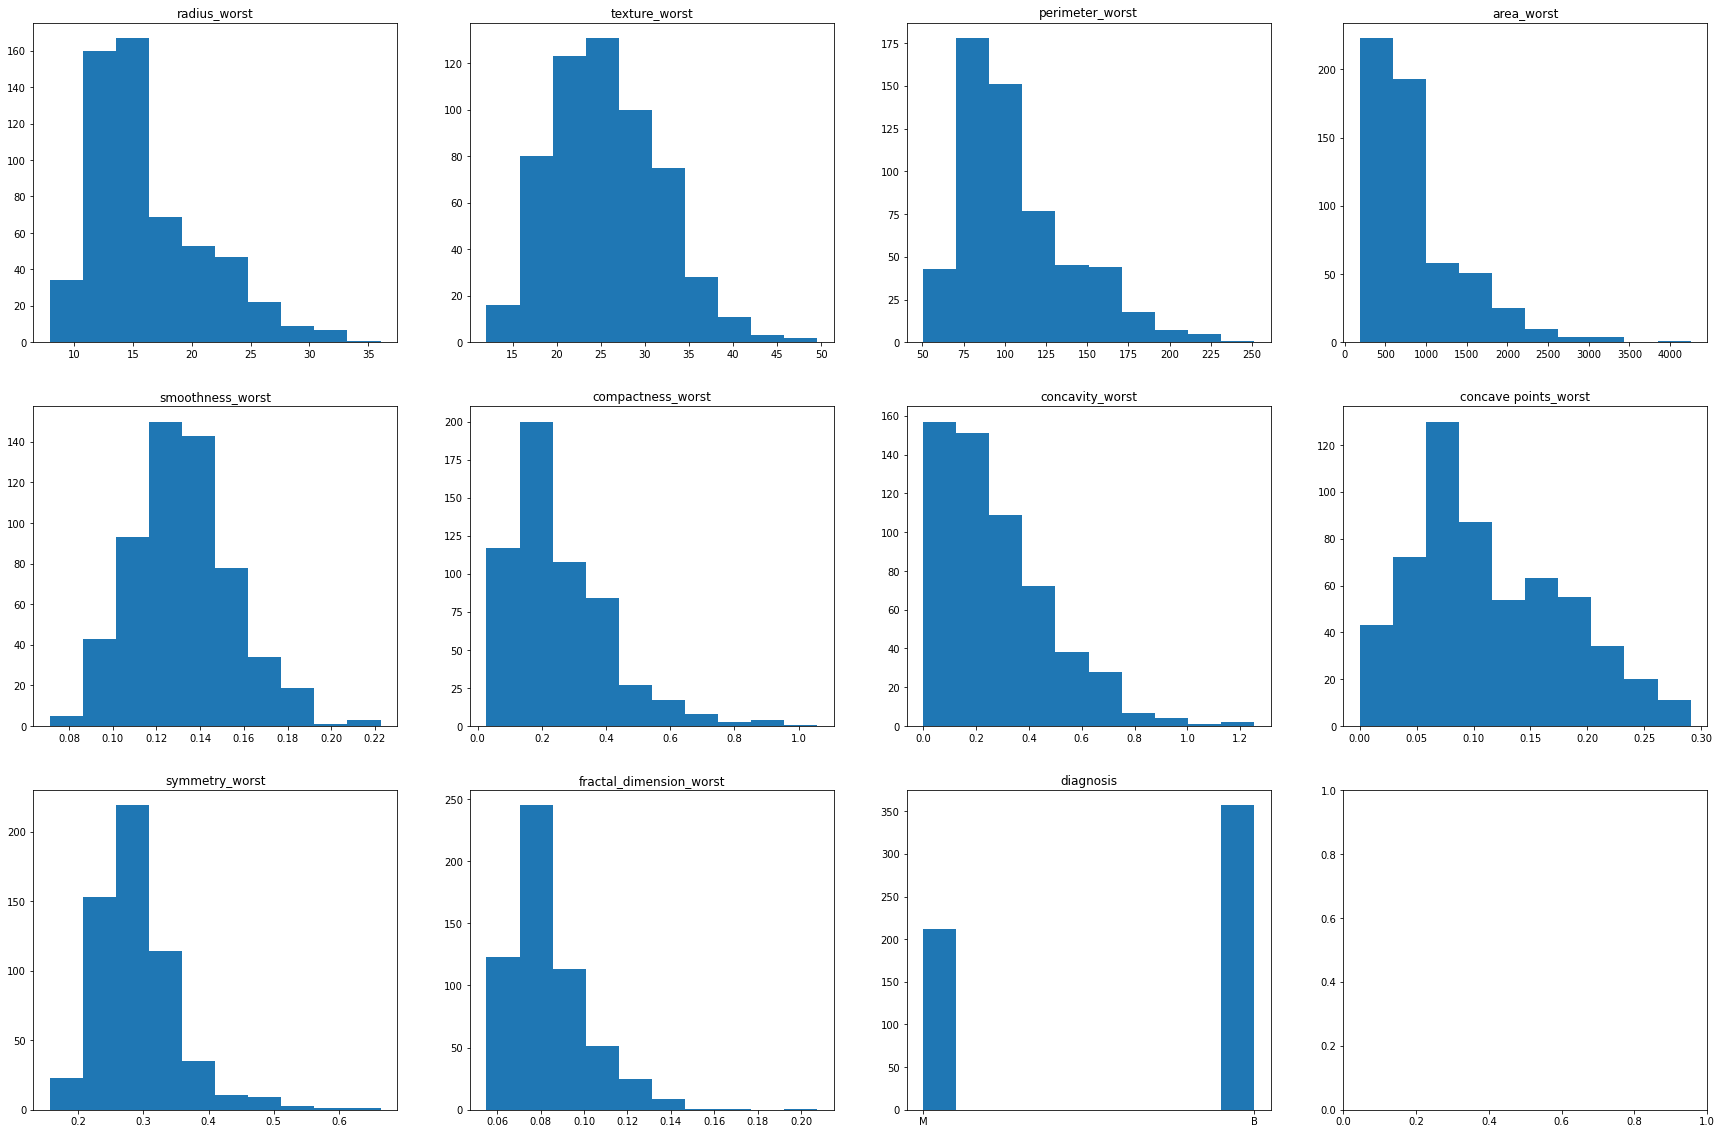

In [ ]:
rows, columns = 3, 4
fig, axs = plt.subplots(rows,columns,figsize=(30,20))
k = 0
for i in range(rows):
  for j in range(columns):
    if k <= 10:
      axs[i,j].hist(df_worst[df_worst.columns.values[k]])
      axs[i,j].set_title(df_worst.columns.values[k])
      k += 1

plt.show()

In [ ]:
df1

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
#Se reemplazan los datos categóricos por datos cuantitativos para un correcto analisis empleando distintos clasificadores (B --> 0, M --> 1)
df2 = df1.replace({'B': 0, 'M': 1})
df2

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


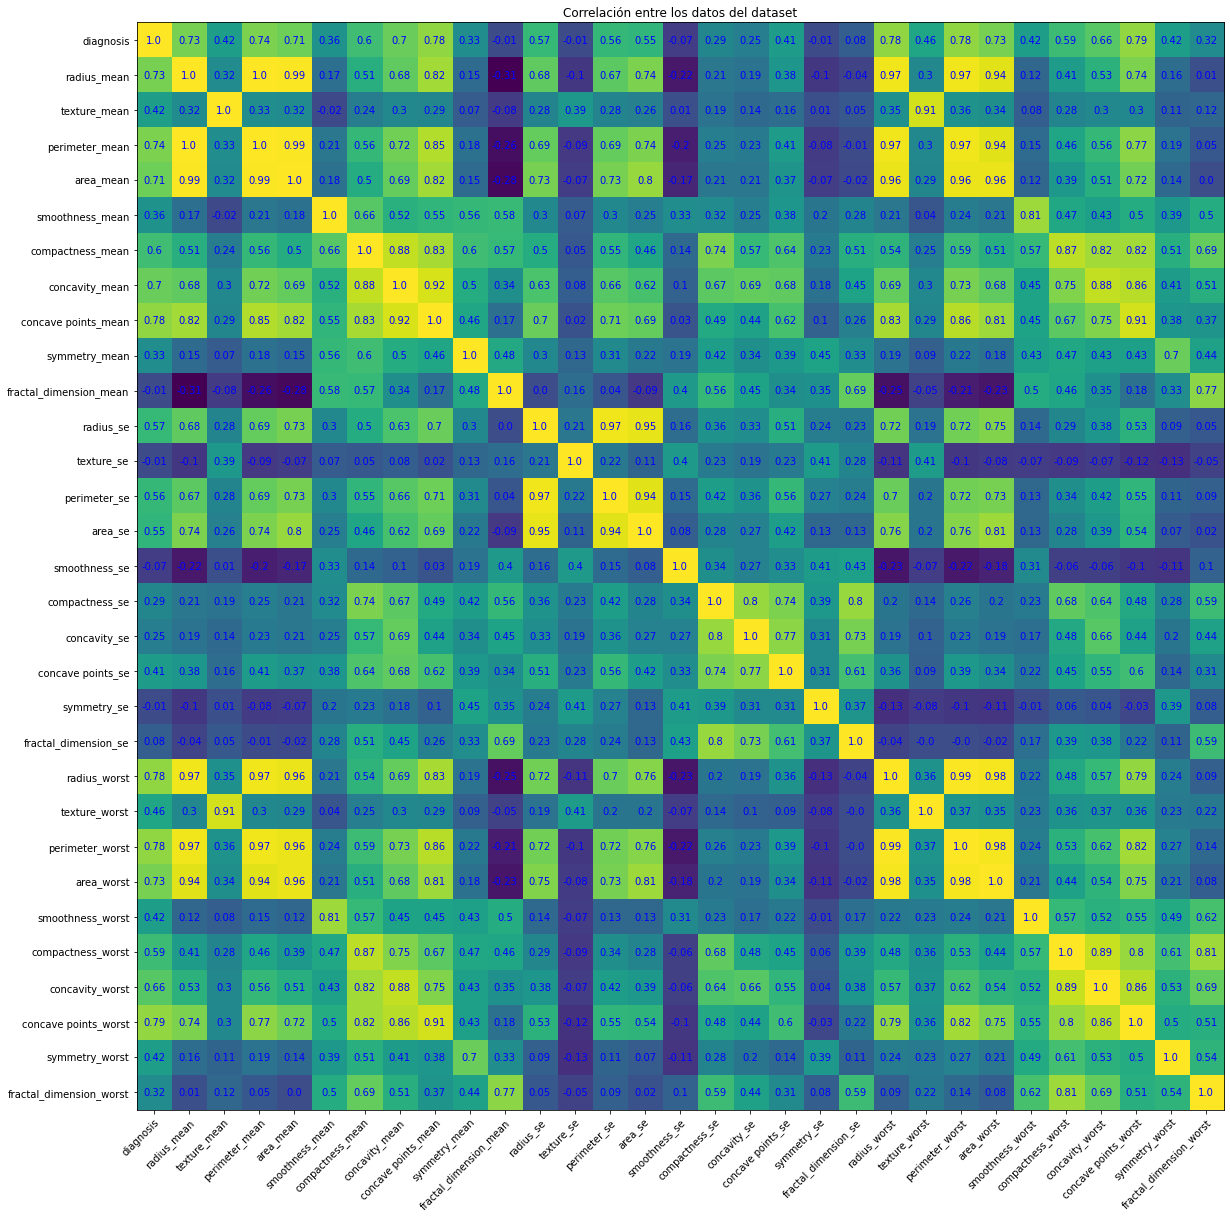

In [ ]:
x_labels = list(df1.columns.values)
y_labels = list(df1.columns.values)

correlation = np.asarray(df2.corr())
correlation = correlation.round(2)
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(correlation)

ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))

ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

#Se rotan los ticks del eje x para poder leerse correctament.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#Se colocan los valores de correlación entre variables
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
       text = ax.text(j, i, correlation[i, j], ha="center", va="center", color="b")

ax.set_title("Correlación entre los datos del dataset")
plt.show()

### 2.1. Eliminación Recursiva de Atributos

Observamos que existen altas correlaciones entre variables, por ello aplicaremos el algoritmo de eliminación recursiva de atributos. Dado un modelo predictivo se asigna un coeficiente de importancia a cada atributo emplenado la clase ExtraTreesClassifier, la cuál implementa un metaestimador que se ajusta a una serie de árboles de decisión aleatorios en varias submuestras del conjunto de datos y utiliza promedios para mejorar la precisión predictiva.

El objetivo de la Eliminación Recursiva de atributos es ir seleccionado en forma recursiva un número cada vez más pequeño de atributos. Primero comienza con todos los atributos del dataset y luego en cada pasada va eliminando aquellos que tenga el menor coeficiente de importancia hasta alcanzar el número de atributos deseado.

In [ ]:
#Separamos la columna objetivo
target = df2['diagnosis']

#Eliminamos la columna objetivo del dataset
df3 = df2.drop(['diagnosis'], axis=1)
columnas = list(df3.columns.values)

n = 20 #Número de atributos a seleccionar
modelo = ExtraTreesClassifier()
recursive_delete = RFE(modelo, n)
recursive_delete = recursive_delete.fit(df3, target)

In [ ]:
# imprimir resultados
atrib = recursive_delete.support_
relevant_features = [columnas[i] for i in list(atrib.nonzero()[0])]
relevant_features.append('diagnosis') #Volvemos a incluir el atributo target junto con los atributos mas relevantes
relevant_features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'diagnosis']

In [ ]:
#Dataframe final con las características más importantes
df4 = df1[relevant_features]
df4

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,1.0950,8.589,153.40,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.5435,3.398,74.08,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.7456,4.585,94.03,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.4956,3.445,27.23,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.7572,5.438,94.44,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,1.1760,7.673,158.70,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,M
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.7655,5.203,99.04,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,M
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.4564,3.425,48.55,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,M
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.7260,5.772,86.22,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,M


## 3. Split del dataset final

In [ ]:
#Función para separar el dataset en entrenamiento, validación y prueba
def train_validate_test_split(df, train_percent=.6, validate_percent=.2):
    np.random.seed(1)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
train, validate, test = train_validate_test_split(df4, 0.85, 0.1)
print(f"Datos de entrenamiento: {train.shape}")
print(f"Datos de validacion: {validate.shape}")
print(f"Datos de prueba: {test.shape}")

X_train = train.iloc[:,:-1]
y_train = train.loc[:,['diagnosis']] #Atributo objetivo: diagnosis

X_validate = validate.iloc[:,:-1]
y_validate = validate.loc[:,['diagnosis']] #Atributo objetivo: diagnosis

X_test = test.iloc[:,:-1]
y_test = test.loc[:,['diagnosis']] #Atributo objetivo: diagnosis

Datos de entrenamiento: (483, 21)
Datos de validacion: (56, 21)
Datos de prueba: (30, 21)


## 4. Entrenamiento y prueba de modelos de clasificadores

###4.1. Support Vector Machine

Accuracy : 90.00%
              precision    recall  f1-score   support

           B       0.89      0.94      0.92        18
           M       0.91      0.83      0.87        12

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.89        30
weighted avg       0.90      0.90      0.90        30



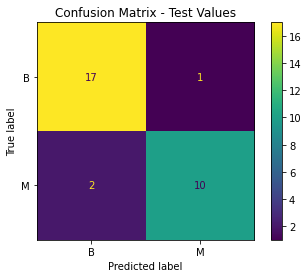

In [ ]:
parameters = {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.01, 0.05, 0.5, 0.1, 1, 10, 15, 20]}

svc = svm.SVC()

cv1 = GridSearchCV(svc, parameters, scoring = 'accuracy')
cv1.fit(X_train, np.ravel(y_train))

y_pred = cv1.predict(X_test)
svc_accuracy = accuracy_score(y_pred, y_test) * 100

print('Accuracy : {:.2f}%'.format(svc_accuracy))
print(classification_report(y_test, y_pred))

confusion_matrix = metrics.plot_confusion_matrix(cv1, X_test, y_test)
plt.title("Confusion Matrix - Test Values")
plt.show()

### 4.2. Random Forest Clasiffier

Accuracy : 96.67%
              precision    recall  f1-score   support

           B       0.95      1.00      0.97        18
           M       1.00      0.92      0.96        12

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



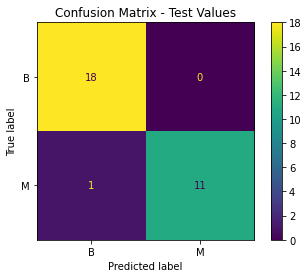

In [ ]:
rfc = RandomForestClassifier(max_depth=5)
rfc.fit(X_train, np.ravel(y_train))

y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_pred, np.ravel(y_test)) * 100

print('Accuracy : {:.2f}%'.format(accuracy))
print(classification_report(y_test, y_pred))

confusion_matrix = metrics.plot_confusion_matrix(rfc, X_test, y_test)
plt.title("Confusion Matrix - Test Values")
plt.show()

### 4.3. Perceptrón con Keras

In [ ]:
y_train_neural = y_train.replace({'B': 0, 'M': 1})
y_validate_neural = y_validate.replace({'B': 0, 'M': 1})
y_test_neural = y_test.replace({'B': 0, 'M': 1})

In [ ]:
dense_model_1 = keras.models.Sequential([
                                       keras.layers.Dense(10, activation='relu', input_shape=[X_train.shape[1]]),
                                       keras.layers.Dense(1, activation='sigmoid')])
dense_model_1.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 11        
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dense_model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
result1 = dense_model_1.fit(X_train, y_train_neural, epochs=20, batch_size=64, validation_data=(X_validate, y_validate_neural))

Epoch 1/20
8/8 [==============================] - 1s 36ms/step - loss: 16.1852 - accuracy: 0.6335 - val_loss: 13.2842 - val_accuracy: 0.5893
Epoch 2/20
8/8 [==============================] - 0s 6ms/step - loss: 11.1217 - accuracy: 0.6335 - val_loss: 8.2222 - val_accuracy: 0.5893
Epoch 3/20
8/8 [==============================] - 0s 4ms/step - loss: 7.0864 - accuracy: 0.6335 - val_loss: 4.7346 - val_accuracy: 0.5893
Epoch 4/20
8/8 [==============================] - 0s 5ms/step - loss: 4.4935 - accuracy: 0.6335 - val_loss: 2.7062 - val_accuracy: 0.5893
Epoch 5/20
8/8 [==============================] - 0s 5ms/step - loss: 3.1098 - accuracy: 0.6335 - val_loss: 1.6374 - val_accuracy: 0.5893
Epoch 6/20
8/8 [==============================] - 0s 5ms/step - loss: 2.1750 - accuracy: 0.6335 - val_loss: 0.8784 - val_accuracy: 0.4821
Epoch 7/20
8/8 [==============================] - 0s 5ms/step - loss: 1.5498 - accuracy: 0.7930 - val_loss: 0.4184 - val_accuracy: 0.8750
Epoch 8/20
8/8 [==============

1/1 [==============================] - 0s 19ms/step - loss: 0.1656 - accuracy: 0.9333


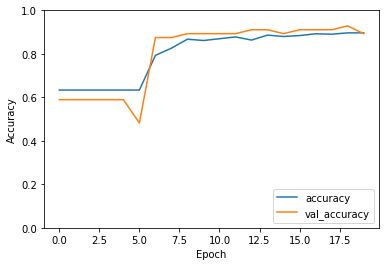

In [ ]:
plt.plot(result1.history['accuracy'], label='accuracy')
plt.plot(result1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = dense_model_1.evaluate(X_test, y_test_neural, verbose=1)

In [ ]:
predictions = dense_model_1.predict(X_test).round()

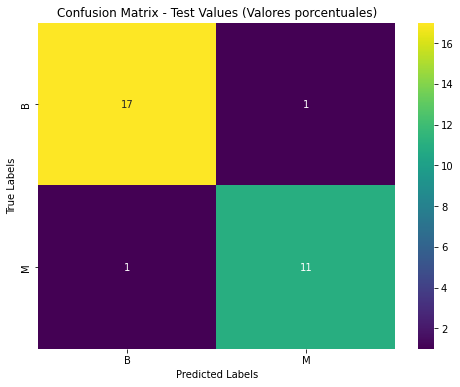

In [ ]:
confusion_matrix_result = metrics.confusion_matrix(y_test_neural, predictions)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result, annot=True, xticklabels=['B','M'], yticklabels=['B','M'], cmap='viridis')
plt.title("Confusion Matrix - Test Values (Valores porcentuales)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 5. Conclusiones

* Se logró adquirir experiencia en el manejo de datasets 
* Se pudo comparar entre 3 clasificadores (Support Vector Machine, Random Forest y Perceptron)
* Se observó como para este caso en particular, el mejor clasificador (aquel que tuvo la mayor presición) fue el clasificador Random Forest, alcanzando una presición cercana al 97%